<a href="https://colab.research.google.com/github/Maryna-Maksimava/Machine_Learning/blob/main/Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('/content/penguins_binary_classification.csv')
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007


In [ ]:
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100
missing_percent

,0
species,0.0
island,0.0
bill_length_mm,0.0
bill_depth_mm,0.0
flipper_length_mm,0.0
body_mass_g,0.0
year,0.0


In [ ]:
exact_duplicates = data.duplicated().sum()
print(f"Number of exact duplicate rows: {exact_duplicates}")

Number of exact duplicate rows: 0


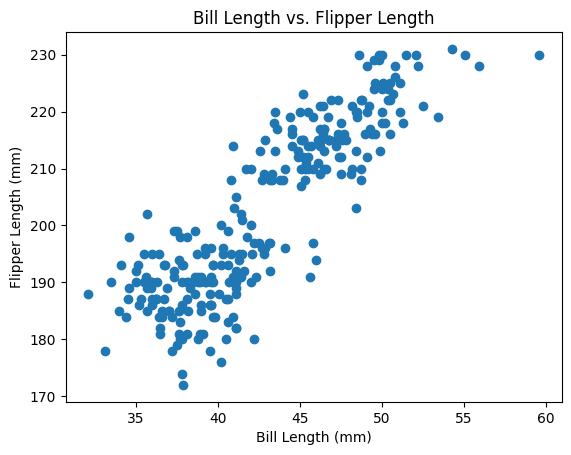

In [ ]:
plt.scatter(data['bill_length_mm'], data['flipper_length_mm'])
plt.xlabel('Bill Length (mm)')
plt.ylabel('Flipper Length (mm)')
plt.title('Bill Length vs. Flipper Length')
plt.show()

In [ ]:
print(data.columns)

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'year'],
      dtype='object')


In [ ]:
data=data.drop(['year', 'island'], axis=1)

In [ ]:
data['species'] = data['species'].map({'Adelie' : 1, 'Gentoo' : 0})

<Axes: >

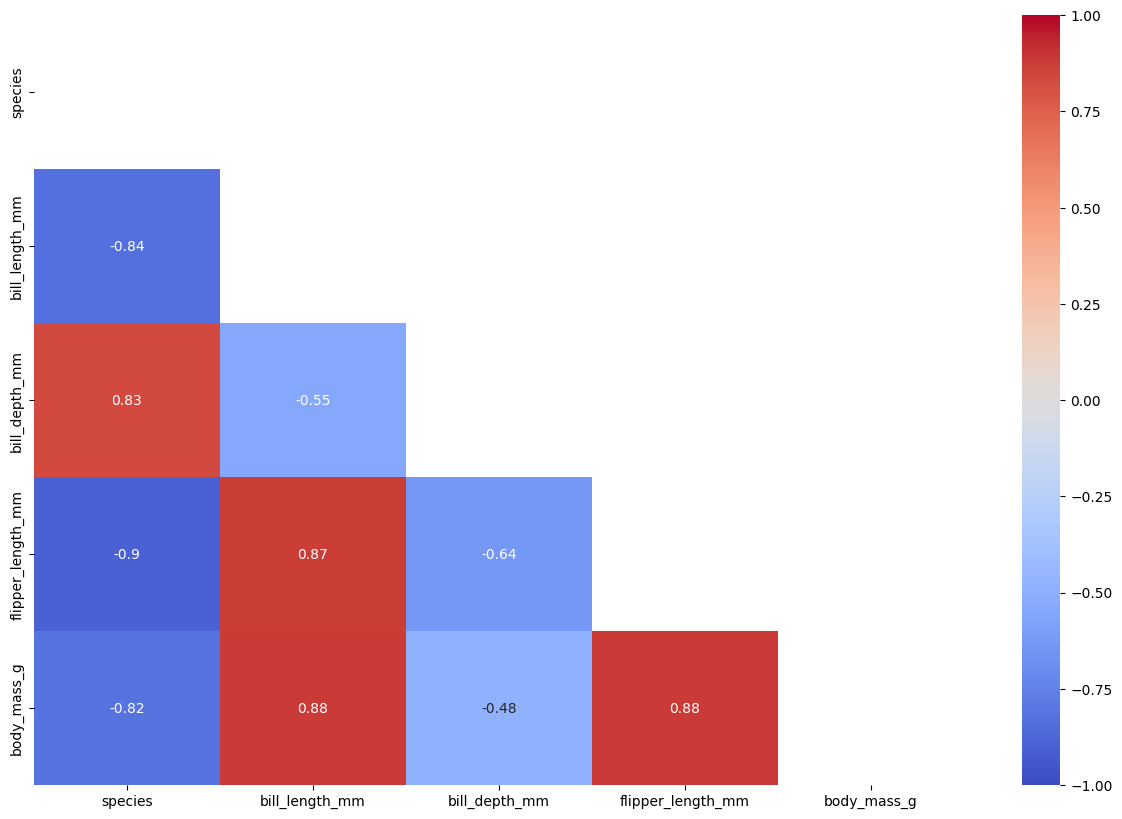

In [ ]:
plt.figure(figsize=(15, 10))
corr_matrix = data.select_dtypes('number').corr()

#Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

#Plot the heatmap with the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)

# ML

In [ ]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(
    data,
    random_state=11
)

In [ ]:
x_train = train.drop('species', axis=1)
y_train = train['species']
x_test = test.drop('species', axis=1)
y_test = test['species']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(x_train)

X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=11)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

# Feature Importances and SHAP

In [ ]:
lrCoef = pd.DataFrame(lr.coef_.round(4)).T
lrCoef['features'] = x_train.columns

In [ ]:
print(lrCoef)

        0           features
0 -1.1855     bill_length_mm
1  2.1652      bill_depth_mm
2 -1.4706  flipper_length_mm
3 -1.2259        body_mass_g


In [ ]:
!pip install shap

In [ ]:
rf_importances = pd.Series(rf.feature_importances_, index=x_train.columns).round(4)
print(rf_importances)

bill_length_mm       0.2429
bill_depth_mm        0.2632
flipper_length_mm    0.4417
body_mass_g          0.0522
dtype: float64


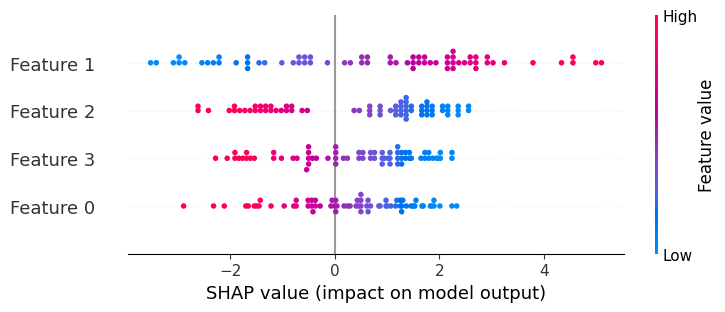

In [ ]:
import shap
explainer_lr = shap.Explainer(lr, X_train_scaled)
shap_values_lr = explainer_lr(X_test_scaled)
shap.plots.beeswarm(shap_values_lr)

In [ ]:
shap.initjs()
shap.plots.force(shap_values_lr[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values_lr[1])

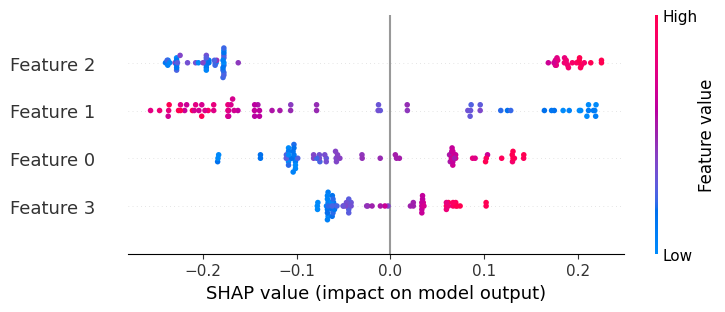

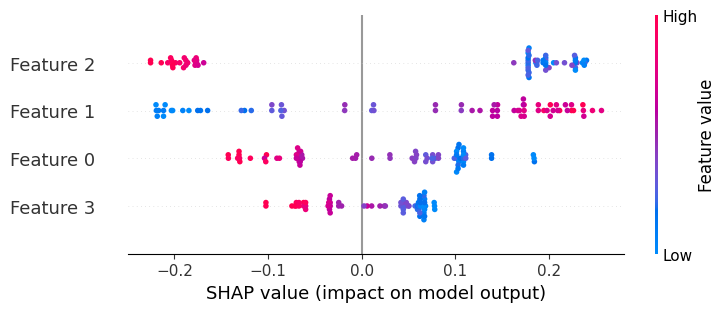

In [ ]:
explainer_rf = shap.Explainer(rf, X_train_scaled)
shap_values_rf = explainer_rf(X_test_scaled,check_additivity=False)
shap.plots.beeswarm(shap_values_rf[..., 0])  # for class 0
shap.plots.beeswarm(shap_values_rf[..., 1])  # for class 1

In [ ]:
expected = explainer_lr.expected_value
prediction = shap_values_lr[0].values.sum() + expected

print(round(prediction, 2))

-4.78


In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
PI = permutation_importance(lr,X_train_scaled,y_train,n_repeats=10,scoring='r2')
PIFrame = pd.DataFrame(PI.importances_mean.round(4))
PIFrame['features'] = x_train.columns
PIFrame.sort_values(by=0,ascending=False)

,0,features
1,0.5200,bill_depth_mm
2,0.0450,flipper_length_mm
0,0.0176,bill_length_mm
3,0.0176,body_mass_g


# Scaled vs. Unscaled. Classification report

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier()

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.98      0.98      0.98        44

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69



In [ ]:
knn_scaled = KNeighborsClassifier()

knn_scaled.fit(x_train_scaled, y_train)

y_pred_scaled = knn_scaled.predict(x_test_scaled)

print(classification_report(y_test, y_pred_scaled))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        44

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [ ]:
lr_scaled = LogisticRegression(random_state=25)

lr_scaled.fit(x_train_scaled, y_train)

y_pred_lr_scaled = lr_scaled.predict(x_test_scaled)

print(classification_report(y_test, y_pred_lr_scaled))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        44

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69

